In [75]:
import torch
import torchvision
from torchvision.utils import make_grid, save_image
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as wdg
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)
import models.Autoencoder as AE

In [2]:
hidden_size = (128,2)
model = AE.VariationalAutoencoder(input_size=(28,28), hidden_size=hidden_size)

In [3]:
#model_path = '../trained_models/VAE_MNIST_2019-03-10_22:52:35.332881_overfitted'
model_path = '../trained_models/VAE_MNIST_2019-03-12_15:11:46.601470/final_model'
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])

In [4]:
cuda = torch.cuda.is_available()
if cuda:
    model.cuda()

In [5]:
loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('../data', train=False, download=True,
                       transform=torchvision.transforms.Compose([
                           torchvision.transforms.ToTensor(),
                           torchvision.transforms.Normalize((0.1307,), (0.3081,))
                       ])),
                        batch_size=1, shuffle=False)

## Test reconstruction of test samples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


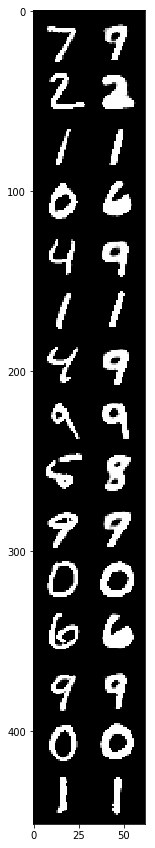

In [56]:
imgs = []
n = 15
for i, (data, target) in enumerate(loader):
    if i > n-1:
        break
    imgs.append(data.squeeze(0))
    mu, log_var = model.encode(data.cuda())
    z = model.sample_z(mu, log_var)
    rec = model.decode(z)
    rec = rec.detach().cpu()
    #print('mu: %s\n\var: %s\n'%(str(mu), str(log_var)))
    imgs.append(rec.squeeze(0))

imgs = make_grid(imgs, nrow=2)
imgs = np.moveaxis(imgs.numpy(), 0, -1)
plt.figure(figsize=(2.0, n))
plt.imshow(imgs)
plt.show()

## Create new samples

In [7]:
eps = torch.randn(hidden_size[1])
if cuda:
    eps = eps.cuda()
img = model.decode(eps)
img = img.squeeze().detach().cpu().numpy()
print(img.shape)

(28, 28)


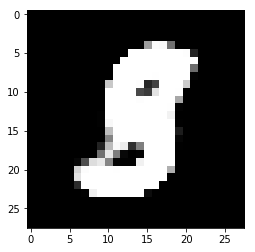

In [8]:
plt.imshow(img, cmap=plt.cm.gray)
plt.show()

### Variety of generated samples

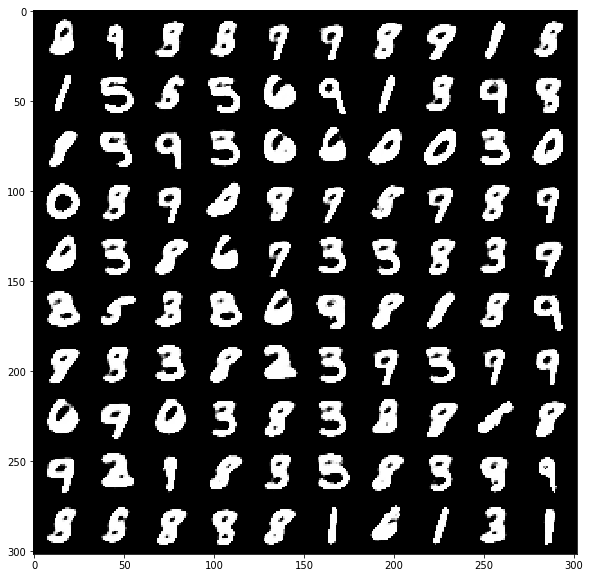

In [55]:
square = 10
imgs = []
for i in range(square**2):
    eps = torch.randn(hidden_size[1])
    if cuda:
        eps = eps.cuda()
    #eps = mu + torch.exp(log_var / 2) * eps
    img = model.decode(eps)
    img = img.squeeze(0).detach().cpu()
    imgs.append(img)
imgs = make_grid(imgs, nrow=square)
plt.figure(figsize=(square, square))
plt.imshow(np.moveaxis(imgs.numpy(), 0, -1), cmap=plt.cm.gray)
plt.show()

## Show regularity in created samples

In [36]:
def plot_img(x, y):
    z = torch.Tensor([x, y])
    if cuda:
        z = z.cuda()
    img = model.decode(z)
    img = img.squeeze().detach().cpu()
    plt.imshow(img, cmap=plt.cm.gray)
    return None

In [37]:
borders = 5.0
wdg.interact(plot_img, x=wdg.FloatSlider(min=-borders, max=borders, step=0.1),y=wdg.FloatSlider(min=-borders, max=borders, step=0.1))

interactive(children=(FloatSlider(value=0.0, description='x', max=5.0, min=-5.0), FloatSlider(value=0.0, descr…

<function __main__.plot_img(x, y)>

Num per dim: 31


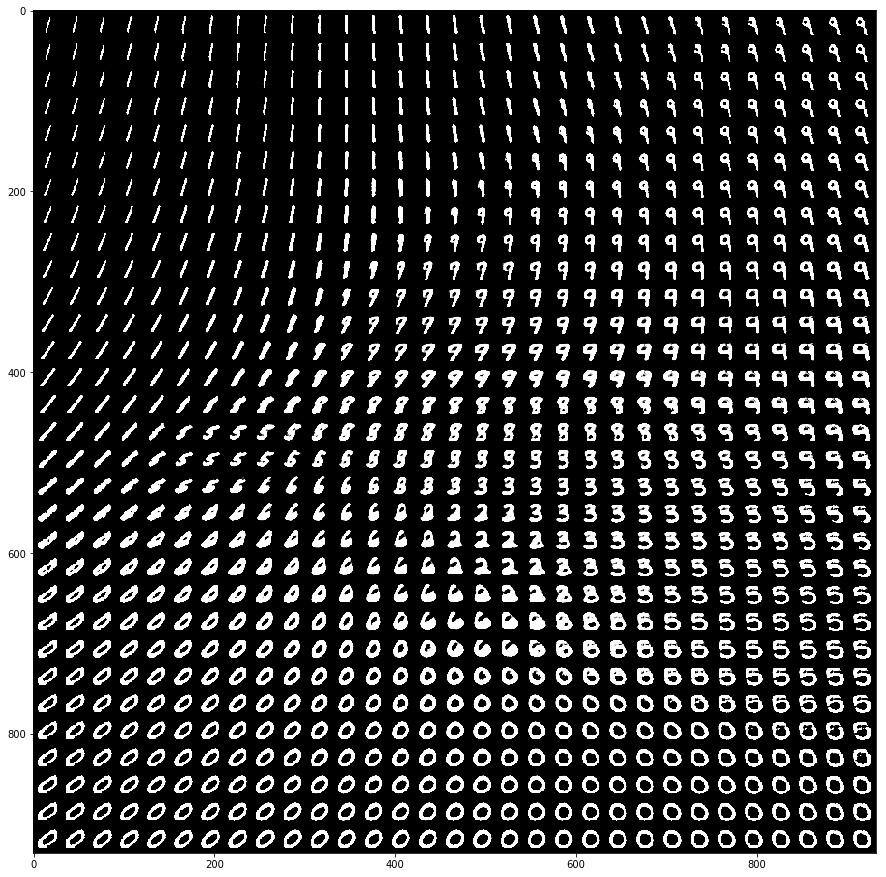

In [88]:
borders = 3.0
spacing = 0.2

num = int((borders*2)/spacing+1.0)
print('Num per dim: %d'%num)
X = np.linspace(-borders, borders, num=num)
Y = np.linspace(-borders, borders, num=num)
imgs = []
for x in X:
    for y in Y:
        z = torch.Tensor([x, y])
        if cuda:
            z = z.cuda()
        img = model.decode(z)
        img = img.squeeze(0).detach().cpu()
        imgs.append(img)
imgs = make_grid(imgs, nrow=num)
plt.figure(figsize=(num/2.0, num/2.0))
plt.imshow(np.moveaxis(imgs.numpy(), 0, -1), cmap=plt.cm.gray)
plt.savefig('../result_figures/VAE_generation.png')
plt.show()